In [ ]:
# pandas-datareader 설치 
!pip install pandas-datareader 

In [ ]:
import pandas as pd
import pandas_datareader.data as dr
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from random import randint

## 1. Data 가져오기

- **데이터를 야후 Finance에서 가져옴.**

- **선택 종목은 애플로 선정함 (주가 코드 : "AAPL").**

- **주가 크롤링 시작일은 '2019,1,1', 마지막일은 '2020,12,31'로 설정함.** 


In [ ]:
def data_load (Name, start,end):
  data = dr.DataReader(Name, 'yahoo',start,end)['Close']
  data = pd.DataFrame(data)

  return data

In [ ]:
# 애플의 종가 데이터가져오기
data = data_load("AAPL", datetime(2019,1,1), datetime(2020,12,31))
data

,Close
Date,
2019-01-02,39.480000
2019-01-03,35.547501
2019-01-04,37.064999
2019-01-07,36.982498
2019-01-08,37.687500
...,...
2020-12-24,131.970001
2020-12-28,136.690002
2020-12-29,134.869995


## 2. 전일 대비 로그 수익률 계산 

- **전일 대비 로그 수익률을 계산하여 In_rate라는 데이터 프레임을 생성함.**

- **2년치의 주가 데이터를 가져와서 In_rate의 size는 (504,1). 이때, 2년 동안 포함된 주말과 공휴일은 제외됨.**

- **2년치의 애플의 주가 로그 수익률을 가지고 histogram을 그려보면, 종 모양의 형태가 나오는 것을 확인할 수 있음.**

\\

**[ 수익률을 구하는 이유]**

  *   **주가 자체는 상승 추세(trend)를 가진, 불안정한 시계열 데이터임(random walk with drift).**
  *   **주가를 1차 차분을 하여 추세를 제거한 수익률은 안정적. 불안정한 주가 대신, 안정적 시계열 데이터인 수익률을 이용하여 부트스트래핑을 해야 함.**
  *   **효율적 시장 가설: 어제의 뉴스는 어제의 주가에 완벽히 반영함. 즉, 어제의 수익률은 어제의 뉴스충격에 따른 결과이며, 오늘의 수익률과는 독립적임.**

In [ ]:
def lnrate (data):
  # 전일 대비 로그 수익률 계산 - ln(오늘주가/전날주가)
  ln_rate = np.log(data / data.shift(1)) 
  ln_rate = ln_rate[1:] # 1번째 행은 전날 종가가 없어서 제외함
  return ln_rate

In [ ]:
ln_rate = lnrate(data)
ln_rate

,Close
Date,
2019-01-03,-0.104924
2019-01-04,0.041803
2019-01-07,-0.002228
2019-01-08,0.018884
2019-01-09,0.016839
...,...
2020-12-24,0.007683
2020-12-28,0.035141
2020-12-29,-0.013404


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34a39e3978>]],
      dtype=object)

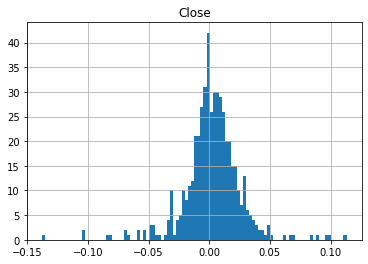

In [ ]:
hist=ln_rate.hist(bins=100)
hist

## 3-4. 계산된 수익률을 이용해 복원추출하여, Bootstrapping을 통해 1년 후 수익률 계산하기

- **2년치의 로그 수익률을 가지고 있는 In_rate에서 부트스트래핑을 함. 이 때 randint함수를 사용하여 In_rate를 복원추출함.** 

- **pred_sp_boostrap이라는 함수는 In_rate를 부트스트래핑하여 1년 후 주가를 예측하는 함수.** 
  - **for문을 2번 이용함. 첫번째 for문은 sampling할 만큼 반복하고, 2번째 for문은 1년에 해당하는 일만큼 반복하여 실행됨. 여기서, 반복한 횟수(N_sam)은 1000이고, 1년 중 주말과 공휴일을 제외해야 하므로 N_day에는 int(365*5/7)값을 사용함.**
  - **결과는 행: 260일, 열:반복수 1000, 값은 예측된 주가로. 260*1000 사이즈의  데이터프래임이 반환됨.**


In [ ]:
def pred_sp_boostrap(data, ln_rate, N_sam, N_day):

  # N_sam: 반복할 갯수, N_day: 예측할 일수 
  
  # 예측한 주가를 저장할 비여있는 데이터프레임 생성. 
  bootstrap_data=pd.DataFrame()
  lost_close=data.iloc[-1,-1] #2년치 주가 데이터의 마지막 주가

  for a in range(N_sam):

    # 2020.12.31 종가를 이용하여 첫번째 주가를 구함. 
    first_close = lost_close * math.exp(ln_rate['Close'][randint(0,503)])

    # 1년의 주가 예측값을 구함.
    sam1=[]
    sam1.append(first_close)

    #sam1=[first_close, first_close*rand]

    for b in range(N_day-1):
      nday_close=sam1[b] * math.exp(ln_rate['Close'][randint(0,503)])
      sam1.append(nday_close)

    # 1년의 예측된 주가를 데이터 프레임의 열에 저장. 
    bootstrap_data[a]=sam1


  return bootstrap_data

- **행은 1년(260일), 열:반복수 1000, 값은 예측된 주가를 나타냄. 즉, 1년 주가 예측을 1000번 함.**

In [ ]:
# 1년 주가예측을 1000번 반복함.
pre_data = pred_sp_boostrap(data, ln_rate, 1000, int(365*(5/7)))
pre_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,135.270579,131.764354,135.123639,131.667937,136.476703,124.978133,132.325596,132.343572,132.650157,127.196338,134.311023,131.480947,131.319084,131.945278,132.866012,137.086932,130.286255,134.440438,131.771861,132.505338,128.743455,146.581137,133.772000,133.205207,132.065955,128.788220,137.577017,136.086154,134.180825,132.292127,132.636645,132.380604,132.690002,135.467514,134.636702,132.556500,131.889446,133.861161,138.108611,125.256970,...,130.858658,134.180825,132.302195,132.866012,132.908266,131.926508,130.576497,132.703326,131.673324,130.349808,129.935796,137.982548,131.826490,135.038290,132.353303,132.891342,126.806696,146.002180,135.616595,132.307593,135.690064,132.415171,134.321815,134.941285,135.748065,135.219488,134.440438,135.616595,132.573518,131.685821,127.196338,135.273881,130.750329,133.580405,129.940874,133.465501,131.087884,136.221806,137.086932,135.690064
1,133.724676,131.437936,136.781598,124.775404,136.801085,124.868419,131.604906,133.694604,134.411163,128.512171,131.561457,137.579633,131.523986,131.731544,137.281721,134.642662,127.094949,139.802803,133.156936,133.281102,129.211828,151.823716,135.259083,132.900599,133.649271,127.316399,142.674299,138.662319,137.083031,129.869786,132.238930,136.966565,132.639649,135.525459,135.706492,145.855284,131.952841,134.094140,137.908478,126.320991,...,123.253226,133.626014,132.334781,132.568892,133.718926,131.529551,131.180995,131.249223,136.036564,133.836694,128.433453,150.828823,128.329482,147.610453,134.513090,132.544386,125.847039,146.242341,136.549274,131.962161,134.355432,133.556214,138.121689,135.018740,138.608810,134.523557,135.967643,122.223824,131.431772,132.636077,124.317245,134.812700,134.230505,130.556809,129.546820,132.926686,134.821397,137.962643,134.834931,135.281783
2,136.325374,132.570559,137.279929,125.422564,137.497524,128.192036,131.917709,134.171830,134.006729,124.493613,131.271654,136.538448,131.888071,132.139587,137.059344,135.123273,123.058505,145.511874,131.880850,130.514626,128.336611,155.400857,137.549265,130.467116,134.622835,123.529676,141.858967,139.588327,138.782220,126.614229,128.305799,138.022883,126.339214,138.420875,135.299572,151.672948,133.426186,133.816399,138.400746,129.207939,...,125.650274,135.175301,137.067829,134.188433,135.365846,128.996797,132.964160,134.050710,137.869298,134.139259,128.562005,153.345656,130.470875,151.536645,131.701272,136.326931,128.568992,147.143108,135.133975,133.678754,134.589271,122.863589,137.369432,138.630520,134.931885,132.966497,137.060230,123.548554,137.528178,134.886528,125.693561,135.634976,133.005341,126.410419,130.414039,133.658453,134.469402,137.830770,132.456907,134.719719
3,137.551498,129.923389,139.268119,124.154508,138.159693,127.674511,132.688694,132.217804,131.230320,122.621595,132.133727,136.675113,131.492601,133.767056,136.711557,134.528767,123.651137,151.910043,134.641425,131.554598,128.211602,154.717135,132.890172,131.342603,134.001794,127.095927,143.617355,139.277764,135.237462,126.566181,128.199717,138.502917,131.732547,141.318348,133.523238,146.535454,135.161822,134.985763,141.558542,128.367087,...,126.256702,134.629584,139.959911,135.237486,137.946341,126.794864,136.741003,136.606135,139.057341,133.789045,133.125147,155.431012,131.100569,152.575424,127.240263,137.132963,130.096309,148.371398,138.317887,136.733856,135.418262,127.119859,138.213346,138.150872,143.502834,134.847814,140.331707,122.194765,140.429484,134.589401,125.154899,131.631896,130.251019,131.763697,134.560567,132.561955,134.334109,138.649177,130.118773,133.963603
4,137.724085,130.338647,141.145228,126.909449,141.108682,130.367943,131.417096,133.452524,131.564734,122.010759,127.868424,136.888372,133.404070,134.247779,136.725284,133.951339,124

- **앞서 구한 1000개의 1년 후 예측된 주가로 그래프를 생성함.**

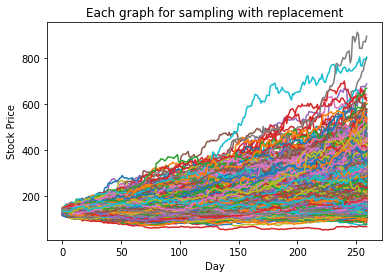

In [ ]:
# 복원 추출 된 각각의 수익률의 주가 그래프 
plt.plot(pre_data)
plt.xlabel("Day")
plt.ylabel("Stock Price")
plt.title("Each graph for sampling with replacement")
plt.show()

- **1000개의 1년 후 예측된 주가들의 평균을 구해 최종적으로 1년 후 주가의 예측값을 추정함.**

In [ ]:
# 1년 후 예측된 주가 
pre_year1_price = pre_data.mean(axis=1)
pre_year1_price

0      133.174841
1      133.445212
2      133.834477
3      134.308943
4      134.672155
          ...    
255    267.599190
256    268.144247
257    268.918584
258    269.515703
259    270.206220
Length: 260, dtype: float64

-  **"Mean of 1000 predicted graphs"는 1000개의 1년 후 예측된 주가들의 평균과 표준편차를 나타냄.** 
  - **빨간점: 평균, 파란선: 표준편차.**

Text(0.5, 1.0, 'Mean of 1000 predicted graphs')

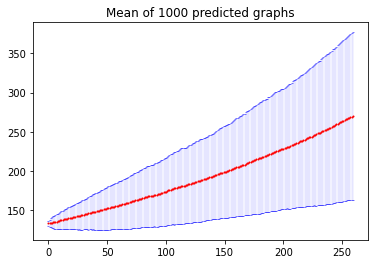

In [ ]:
# 1년 후 예측된 주가의 그래프 
pre_year1_data = pd.DataFrame({"Day": np.arange(len(pre_data)),
                               "Mean": pre_data.mean(axis=1),
                               "Sd": pre_data.std(axis=1)})
plt.errorbar(x=pre_year1_data["Day"], 
             y=pre_year1_data["Mean"], 
             yerr=pre_year1_data["Sd"], 
             fmt="o", 
             Color = 'red',
             MarkerSize = 1,
             elinewidth=0.1,
             ecolor='blue',
             capsize=1,
             capthick=0.5 
             )
plt.title("Mean of 1000 predicted graphs")

# 분석 결과 


1.**예측 된 주가에 대한 판단** 
- **애플의 2019-01-02의 주가는 39.48, 2020-12-31의 주가는 132.69임. 약 2년 동안 3배가 넘는 주가 상승이 일어남.따라서 20.12.31일을 기준으로 1년 후 주가는 대략 3^(1/2)배 정도 큰 수치가 예측되야함.**
- **우리가 예측한 1000개의 1년 주가를 평균을 낸 값을 보면, 앞으로 1년뒤의 애플의 주가 예측치는 270.21달러임. 2020-12-31의 주가인 132.69달러에 비해 2배가 약간 넘는 값으로 충분히 납득할 만한 예측값이라고 판단됨.**

\\
2. **시간이 지날 수록 예측값의 분산이 커짐.**